In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
from scipy import stats
import math

from sklearn import base, model_selection, metrics, discriminant_analysis, pipeline
from sklearn.base import BaseEstimator, TransformerMixin, clone

import seaborn as sns
import matplotlib.pyplot as plt

import constants
import dataset
import folders


In [78]:
plt.rcParams['figure.figsize']=(1,5)
plt.rcParams['figure.dpi'] = 200 
plt.rcParams['savefig.dpi'] = 200

sns.set(font_scale=1, palette='colorblind') 
sns.set_context(context='paper')
sns.set_style("white")


In [3]:
ds = dataset.DatasetReader(data_path=folders.database_path_1hz, preload=True)

99 percent complete

In [4]:
class downsampler(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.downsample_div = 10
        pass
    def fit(self, data, y=None):
        return self
    def transform(self, data):
        return data[:, :, ::self.downsample_div]

class channel_selector(BaseEstimator, TransformerMixin):
    def __init__(self, classifier_channels = [16,17,18,19,20,25,27,29,34,36,42]):
     self.classifier_channels = classifier_channels
    def fit(self, data, y=None):
        return self
    def transform(self, data):
        if self.classifier_channels:
            return data[:, self.classifier_channels, :]
        else:
            return data

class epoch_cutter(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, data, y=None):
        return self
    def transform(self, data):
        return data[:, :, int(abs(constants.epochs_tmin*constants.fs)):]

class reshaper(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, data, y=None):
        return self
    def transform(self, data):
        s = data.shape
        data= data.reshape((s[0], s[1]*s[2]))
        return data     

class printer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, data, y=None):
        return self
    def transform(self, data):
        print (f'data shape after preproc: {data.shape}')
        return data

def score_func(y, y_pred, **kwargs):
    target_p = [a for a, b in zip(y_pred, y) if b]
    nontarget_p = [a for a, b in zip(y_pred, y) if not b]
    nontarget_p = np.array_split(nontarget_p, len(nontarget_p)/len(target_p))
    nontarget_p = np.mean(nontarget_p, axis=1)
    target_p = np.mean(target_p)
    if len(np.where(nontarget_p>target_p)[0]) == 0:
        return 1
    else:
        return 0

LDA = discriminant_analysis.LinearDiscriminantAnalysis(solver = 'lsqr', shrinkage='auto')

preproc_pipe = pipeline.make_pipeline(
        epoch_cutter(),
        channel_selector(),
        downsampler(),
        reshaper(),
        # printer()
        )

PIPE = pipeline.make_pipeline(preproc_pipe, LDA)

In [115]:
def bits_per_trial(p, n=8):
    bpm =  math.log(n, 2) 
    if p !=0:
        bpm += p*math.log(p,2) 
    if p !=1:
        bpm+=(1-p)*math.log(((1-p)/(n-1)), 2)
    return bpm

def create_dataframe(totals, rng):
    tb = pd.DataFrame({'repeats':np.ravel([[a]*len(totals[0]) for a in rng]), 'accuracy':np.ravel(totals)})
    tb['bits_per_trial'] = list(map(bits_per_trial, tb['accuracy']))
    tb['itr'] = tb['bits_per_trial']*(60/(0.3*8*tb['repeats']))
    return tb

def boxplot(*args, ylabel='', xticks=['small', 'large']):
    sns.set(context='notebook', style='white')    
    sns.boxplot(data=args, color='white')
    sns.swarmplot(data=args)
    sns.utils.axlabel(xlabel=None, ylabel=ylabel, fontsize=16)
    plt.xticks(plt.xticks()[0], xticks)
    plt.axhline(1/8, linestyle='--')

def remove_outliers(df):
    df = pd.DataFrame(df)
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    return df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]
    
def mwtest(*args):
    st =  stats.mannwhitneyu(args[0], args[1])
    print(st)
    return st


def med(*args):
    st =  [np.median(a) for a in args]
    print(st)
    return st

def ttest_ind(*args):
    st =  stats.ttest_ind(args[0], args[1])
    print(st)
    return st

def classifier_metrics_aggergated(ds, subset=None, n_repeats=10, n_splits=100):
    n_stimuli = len(set(subset['event']))
    total_scores = []
    users = sorted(set(subset['user']))
    for user in users:
        user_subset = subset[subset['user'] == user]
        X = ds.create_mne_epochs_from_subset(user_subset)
        
        PIPE.fit(X._data, y=X.events[:,-1])
        skf = model_selection.StratifiedShuffleSplit(test_size=n_stimuli*n_repeats, train_size=480, n_splits=n_splits)
        scores = model_selection.cross_val_score(PIPE,
                                X._data,
                                X.events[:,-1],
                                cv=skf,
                                scoring=metrics.make_scorer(score_func, needs_proba=True), verbose=1, n_jobs=-1)
        total_scores.append(np.mean(scores))
    return total_scores

In [ ]:
large_stims_total = classifier_metrics_aggergated(ds=ds, 
    subset= ds.markup.loc[(ds.markup['reg'] == 'brl_static6_all8')]
        )

small_stims_total = classifier_metrics_aggergated(ds=ds, 
    subset= ds.markup.loc[(ds.markup['reg'] == 'brl_static6_all1')]
        )

[0.71, 0.6000000000000001]
MannwhitneyuResult(statistic=158.5, pvalue=0.13349017497870452)
Ttest_indResult(statistic=array([1.2736365]), pvalue=array([0.21052789]))


Text(0.5, 0.98, 'total')

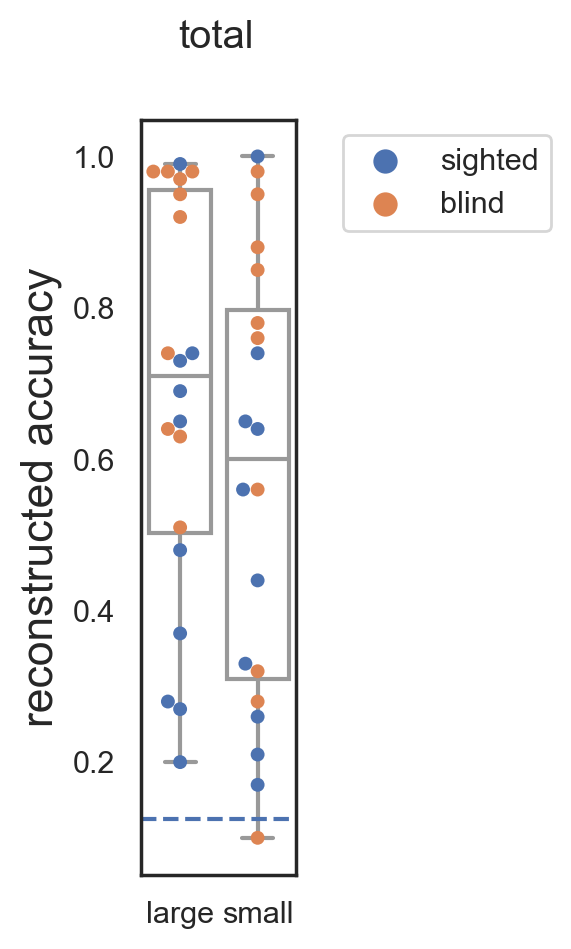

In [116]:
med(remove_outliers(large_stims_total), remove_outliers(small_stims_total))
mwtest(remove_outliers(large_stims_total), remove_outliers(small_stims_total))
ttest_ind(remove_outliers(large_stims_total), remove_outliers(small_stims_total))

def boxplot_from_df(data, ylabel='', xticks=['small', 'large']):
    sns.set(context='notebook', style='white')    
    sns.boxplot(x = data['reg'], y=data['accuracy'] , color='white')
    sns.swarmplot(x = data['reg'], y=data['accuracy'], hue = data['blind'])
    sns.utils.axlabel(xlabel=None, ylabel=ylabel, fontsize=16)
    plt.xticks(plt.xticks()[0], xticks)
    plt.axhline(1/8, linestyle='--')
    L = plt.legend()
    L.set_bbox_to_anchor((1.2, 1))
    L.get_texts()[0].set_text('sighted')
    L.get_texts()[1].set_text('blind')
    
bl = [ds.markup.loc[ds.markup['user'] == user].iloc[0]['blind'] for user in sorted(set(ds.markup['user']))]

dic = {
              'accuracy':large_stims_total + small_stims_total, 
              'reg':[0 for a in large_stims_total] + [1 for a in small_stims_total], 
              'blind':bl + bl
             }

data = pd.DataFrame(dic)

boxplot_from_df(data, xticks=['large', 'small'], ylabel='reconstructed accuracy')



plt.suptitle('total')

In [ ]:
large_stims_blind = classifier_metrics_aggergated(ds=ds, 
    subset= ds.markup.loc[(ds.markup['reg'] == 'brl_static6_all8') &
                          (ds.markup['blind'] == 1)]
        )

small_stims_blind = classifier_metrics_aggergated(ds=ds, 
    subset= ds.markup.loc[(ds.markup['reg'] == 'brl_static6_all1') &
                          (ds.markup['blind'] == 1)]
        )

[0.935, 0.79]
MannwhitneyuResult(statistic=30.5, pvalue=0.07461712320602441)
Ttest_indResult(statistic=array([1.71273898]), pvalue=array([0.10393269]))


Text(0.5, 0.98, 'blind')

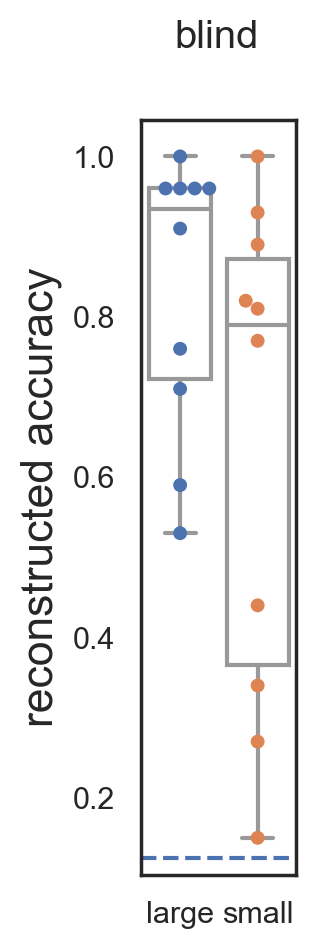

In [117]:
med(remove_outliers(large_stims_blind), remove_outliers(small_stims_blind))
mwtest(remove_outliers(large_stims_blind), remove_outliers(small_stims_blind))
ttest_ind(remove_outliers(large_stims_blind), remove_outliers(small_stims_blind))

boxplot(large_stims_blind, small_stims_blind, xticks=['large', 'small'], ylabel='reconstructed accuracy')
plt.suptitle('blind')

In [ ]:
large_stims_sighted = classifier_metrics_aggergated(ds=ds, 
    subset= ds.markup.loc[(ds.markup['reg'] == 'brl_static6_all8')&
                          (ds.markup['blind'] == 0)]
        )
small_stims_sighted = classifier_metrics_aggergated(ds=ds, 
    subset= ds.markup.loc[(ds.markup['reg'] == 'brl_static6_all1')&
                          (ds.markup['blind'] == 0)]
        )

[0.5700000000000001, 0.48]
MannwhitneyuResult(statistic=44.0, pvalue=0.3385057560112247)
Ttest_indResult(statistic=array([0.34500426]), pvalue=array([0.7340898]))


Text(0.5, 0.98, 'sighted')

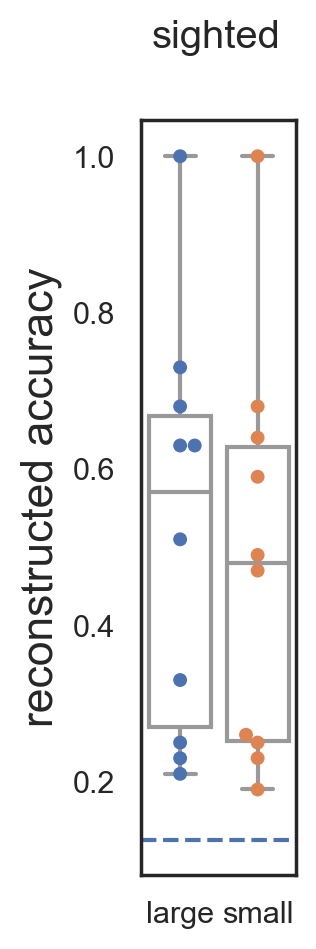

In [118]:
med(remove_outliers(large_stims_sighted), remove_outliers(small_stims_sighted))
mwtest(remove_outliers(large_stims_sighted), remove_outliers(small_stims_sighted))
ttest_ind(remove_outliers(large_stims_sighted), remove_outliers(small_stims_sighted))
boxplot(large_stims_sighted, small_stims_sighted, xticks=['large', 'small'], ylabel='reconstructed accuracy')
plt.suptitle('sighted')

In [ ]:
blind_l = classifier_metrics_aggergated(ds=ds, 
    subset= ds.markup.loc[(ds.markup['reg'] == 'brl_static6_all8') &
                          (ds.markup['blind'] == 1)]
        )
sighted_l = classifier_metrics_aggergated(ds=ds, 
    subset= ds.markup.loc[(ds.markup['reg'] == 'brl_static6_all8') &
                          (ds.markup['blind'] == 0)]
        )

[0.925, 0.595]
MannwhitneyuResult(statistic=18.5, pvalue=0.009487363343667564)
Ttest_indResult(statistic=array([2.96377967]), pvalue=array([0.00831446]))


Text(0.5, 0.98, 'blind vs sighted, large')

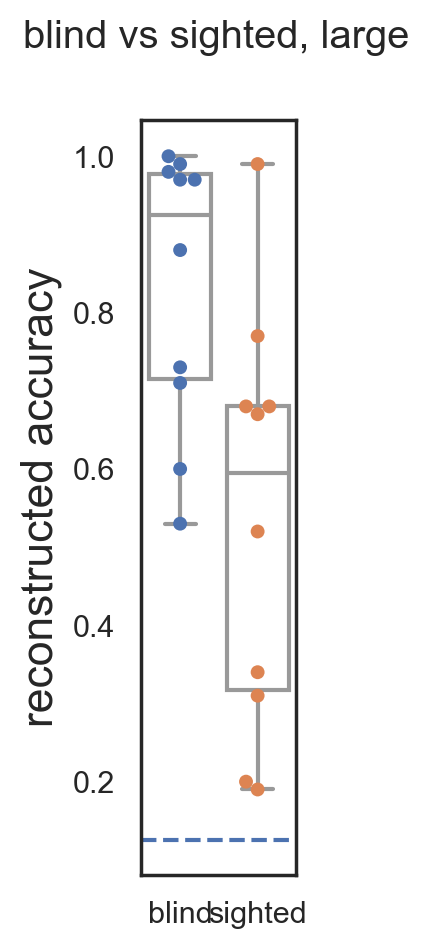

In [119]:
med(remove_outliers(blind_l), remove_outliers(sighted_l))
mwtest(remove_outliers(blind_l), remove_outliers(sighted_l))
ttest_ind(remove_outliers(blind_l), remove_outliers(sighted_l))
boxplot(blind_l, sighted_l, xticks=['blind', 'sighted'], ylabel='reconstructed accuracy')
plt.suptitle('blind vs sighted, large')

In [ ]:
blind_s = classifier_metrics_aggergated(ds=ds, 
    subset= ds.markup.loc[(ds.markup['reg'] == 'brl_static6_all1') &
                          (ds.markup['blind'] == 1)]
        )
sighted_s = classifier_metrics_aggergated(ds=ds, 
    subset= ds.markup.loc[(ds.markup['reg'] == 'brl_static6_all1') &
                          (ds.markup['blind'] == 0)]
        )

[0.77, 0.485]
Ttest_indResult(statistic=array([1.2278707]), pvalue=array([0.23531075]))
MannwhitneyuResult(statistic=32.5, pvalue=0.0992978793166076)


Text(0.5, 0.98, 'blind vs sighted, small')

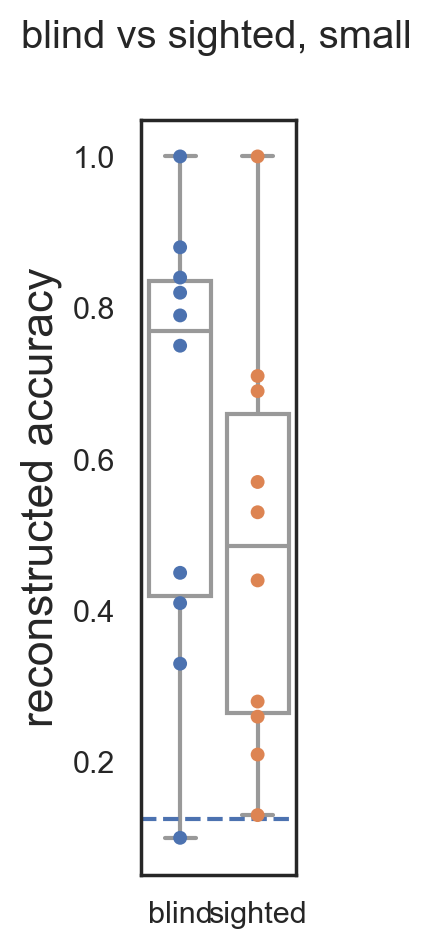

In [120]:
med(remove_outliers(blind_s), remove_outliers(sighted_s))
ttest_ind(remove_outliers(blind_s), remove_outliers(sighted_s))
mwtest(remove_outliers(blind_s), remove_outliers(sighted_s))
boxplot(blind_s, sighted_s, xticks=['blind', 'sighted'], ylabel='reconstructed accuracy')
plt.suptitle('blind vs sighted, small')

In [ ]:
totals_blind_large = []
totals_sighted_large = []
totals_blind_small = []
totals_sighted_small = []
rng=range(1, 12)

subset_blind = ds.markup.loc[(ds.markup['reg'] == 'brl_static6_all8') &
                             (ds.markup['blind'] == 1)
                             ]
for a in rng:
    print (f"cross-vallidation of {a} repeats")
    ts = classifier_metrics_aggergated(ds, subset_blind, n_repeats=a)
    totals_blind_large.append(ts)
print ('totals_blind_large created')

subset_sighted = ds.markup.loc[(ds.markup['reg'] == 'brl_static6_all8') &
                               (ds.markup['blind'] == 0)
                               ]
for a in rng:
    print (f"cross-vallidation of {a} repeats")
    ts = classifier_metrics_aggergated(ds, subset_sighted, n_repeats=a)
    totals_sighted_large.append(ts)
print ('totals_sighted_large created')

subset_blind = ds.markup.loc[(ds.markup['reg'] == 'brl_static6_all1') &
                             (ds.markup['blind'] == 1)
                             ]
for a in rng:
    print (f"cross-vallidation of {a} repeats")
    ts = classifier_metrics_aggergated(ds, subset_blind, n_repeats=a)
    totals_blind_small.append(ts)
print ('totals_blind_small created')

subset_sighted = ds.markup.loc[(ds.markup['reg'] == 'brl_static6_all1') &
                               (ds.markup['blind'] == 0)
                               ]
for a in rng:
    print (f"cross-vallidation of {a} repeats")
    ts = classifier_metrics_aggergated(ds, subset_sighted, n_repeats=a)
    totals_sighted_small.append(ts)
print ('totals_sighted_small created')
                                
tb_l = create_dataframe(totals_blind_large, rng)
ts_l = create_dataframe(totals_sighted_large, rng)
tb_s = create_dataframe(totals_blind_small, rng)
ts_s = create_dataframe(totals_sighted_small, rng)

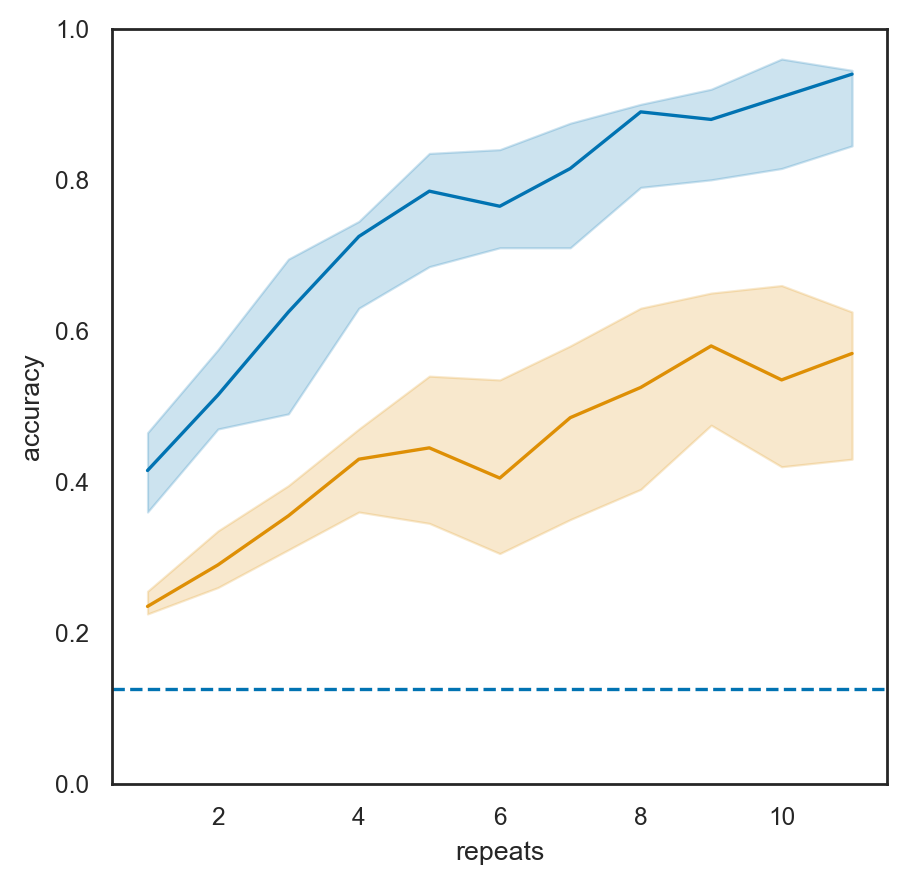

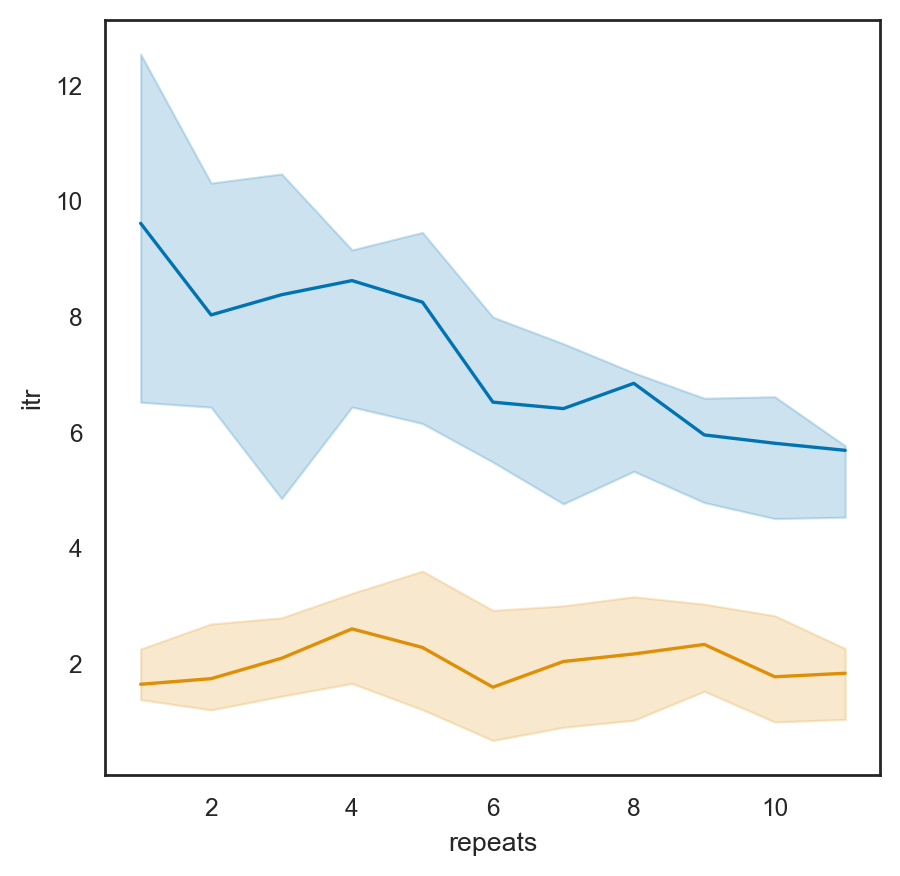

In [25]:
with sns.color_palette("colorblind"):
    sns.lineplot (x='repeats', y='accuracy', data=tb_l, estimator=np.median, ci=50)
    sns.lineplot (x='repeats', y='accuracy', data=ts_l, estimator=np.median, ci=50)
    plt.axhline(1/8, linestyle='--')
    plt.ylim(0,1)
plt.show()
with sns.color_palette("colorblind"):
    sns.lineplot (x='repeats', y='itr', data=tb_l, estimator=np.median, ci=50)
    sns.lineplot (x='repeats', y='itr', data=ts_l, estimator=np.median, ci=50)
plt.show()


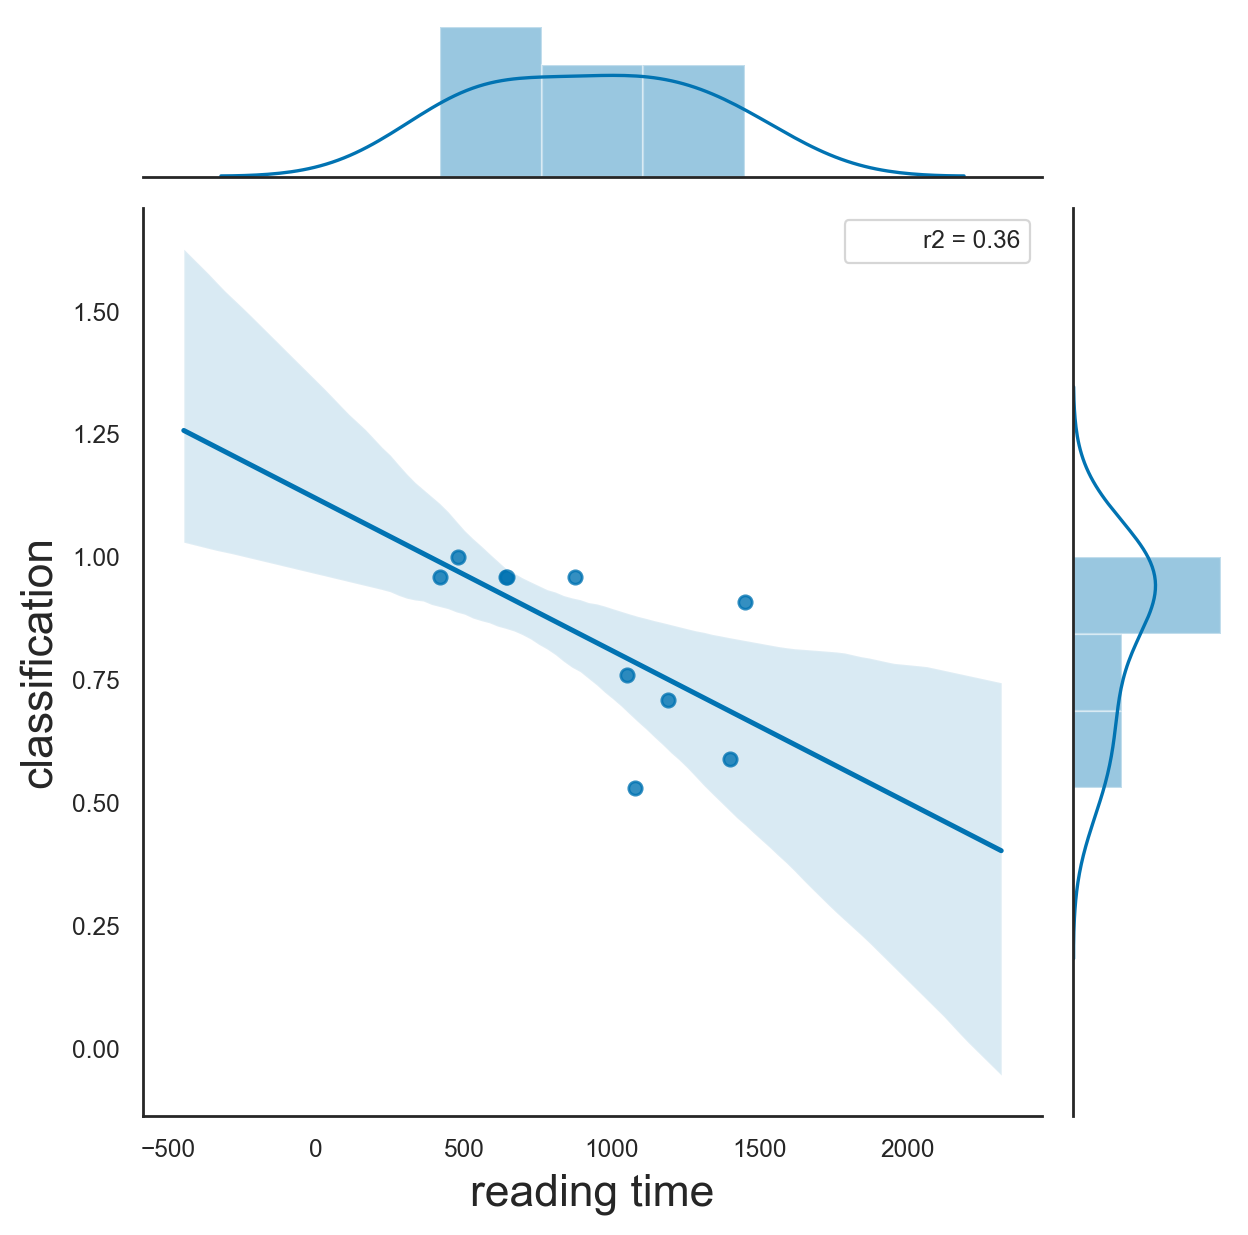

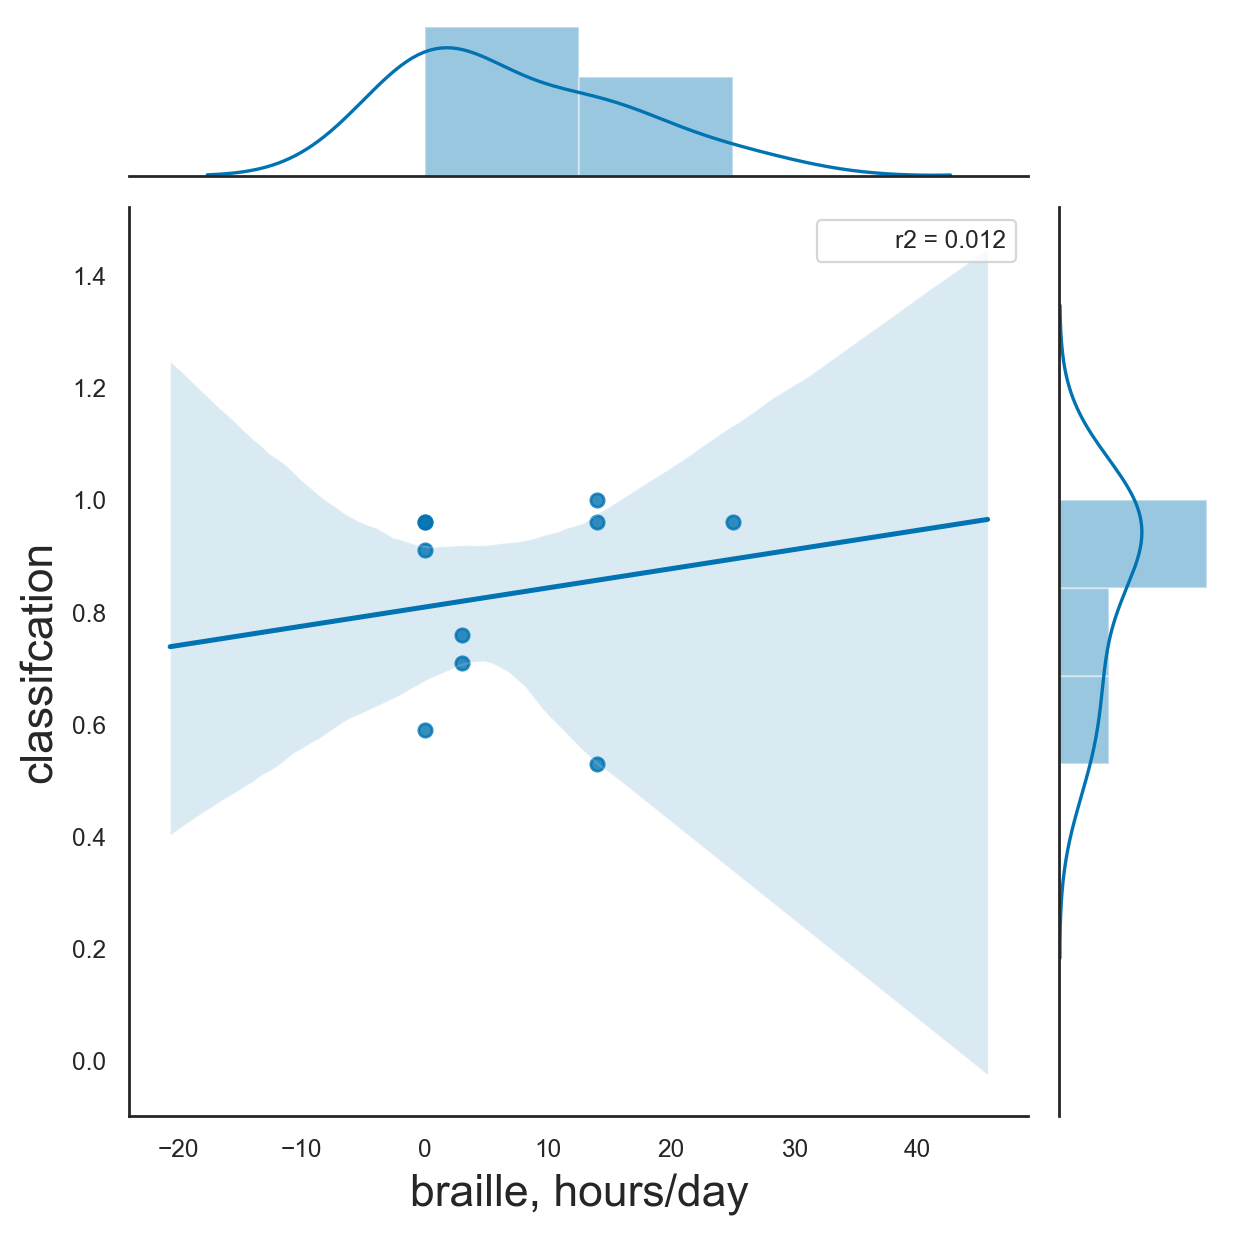

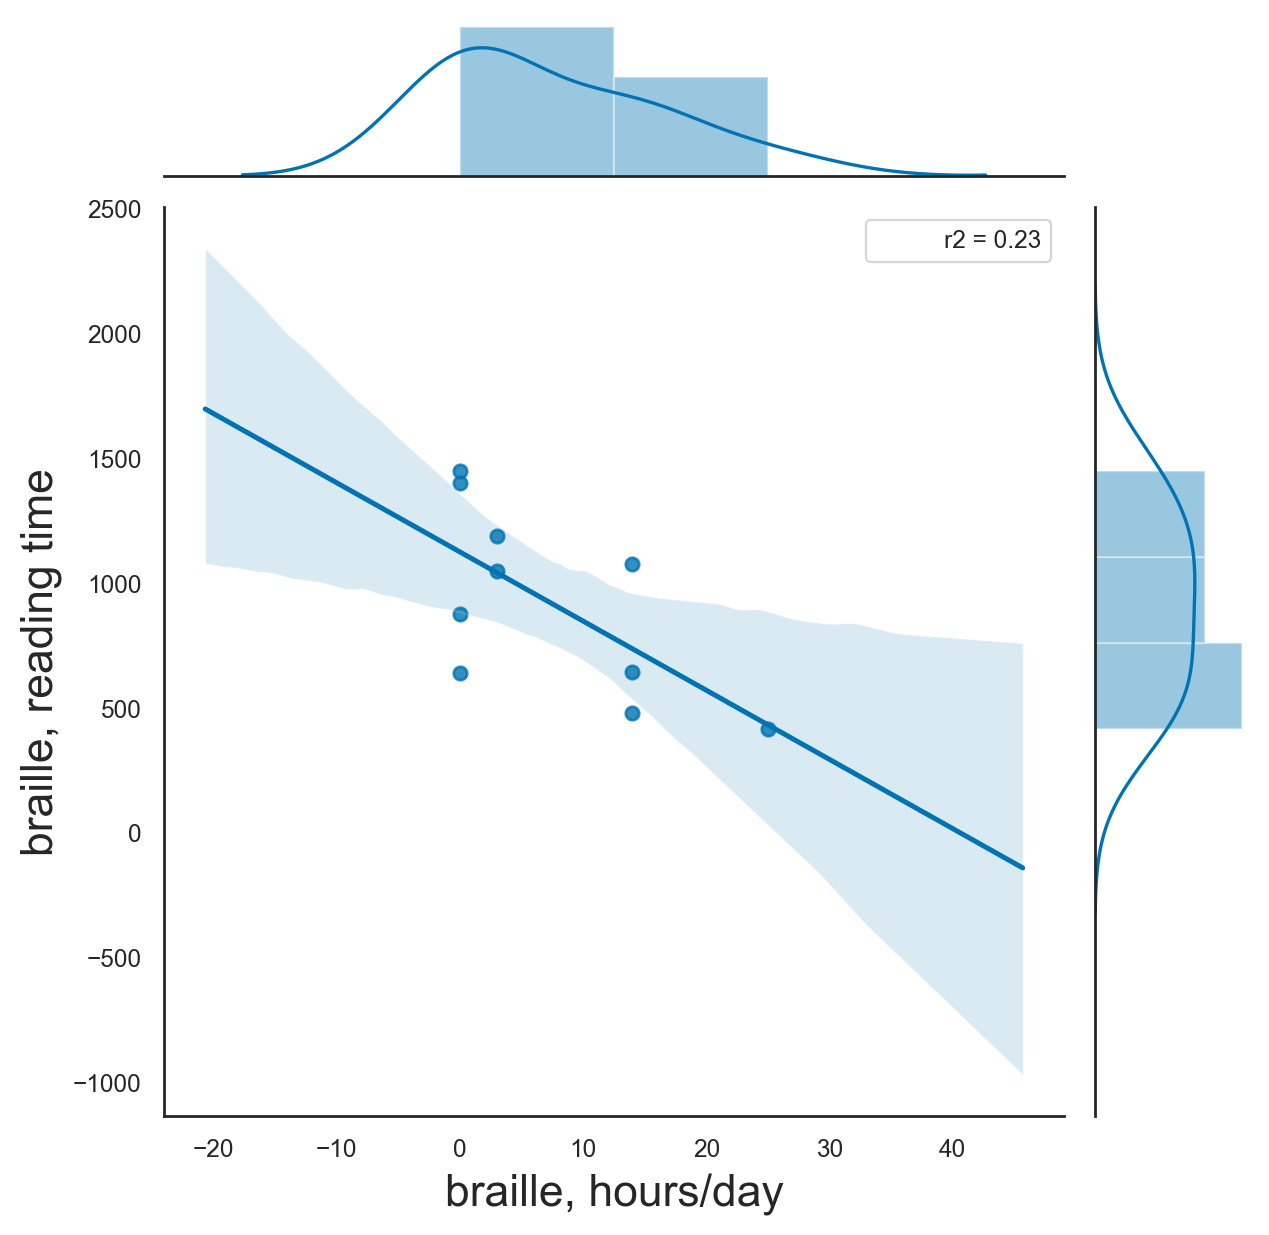

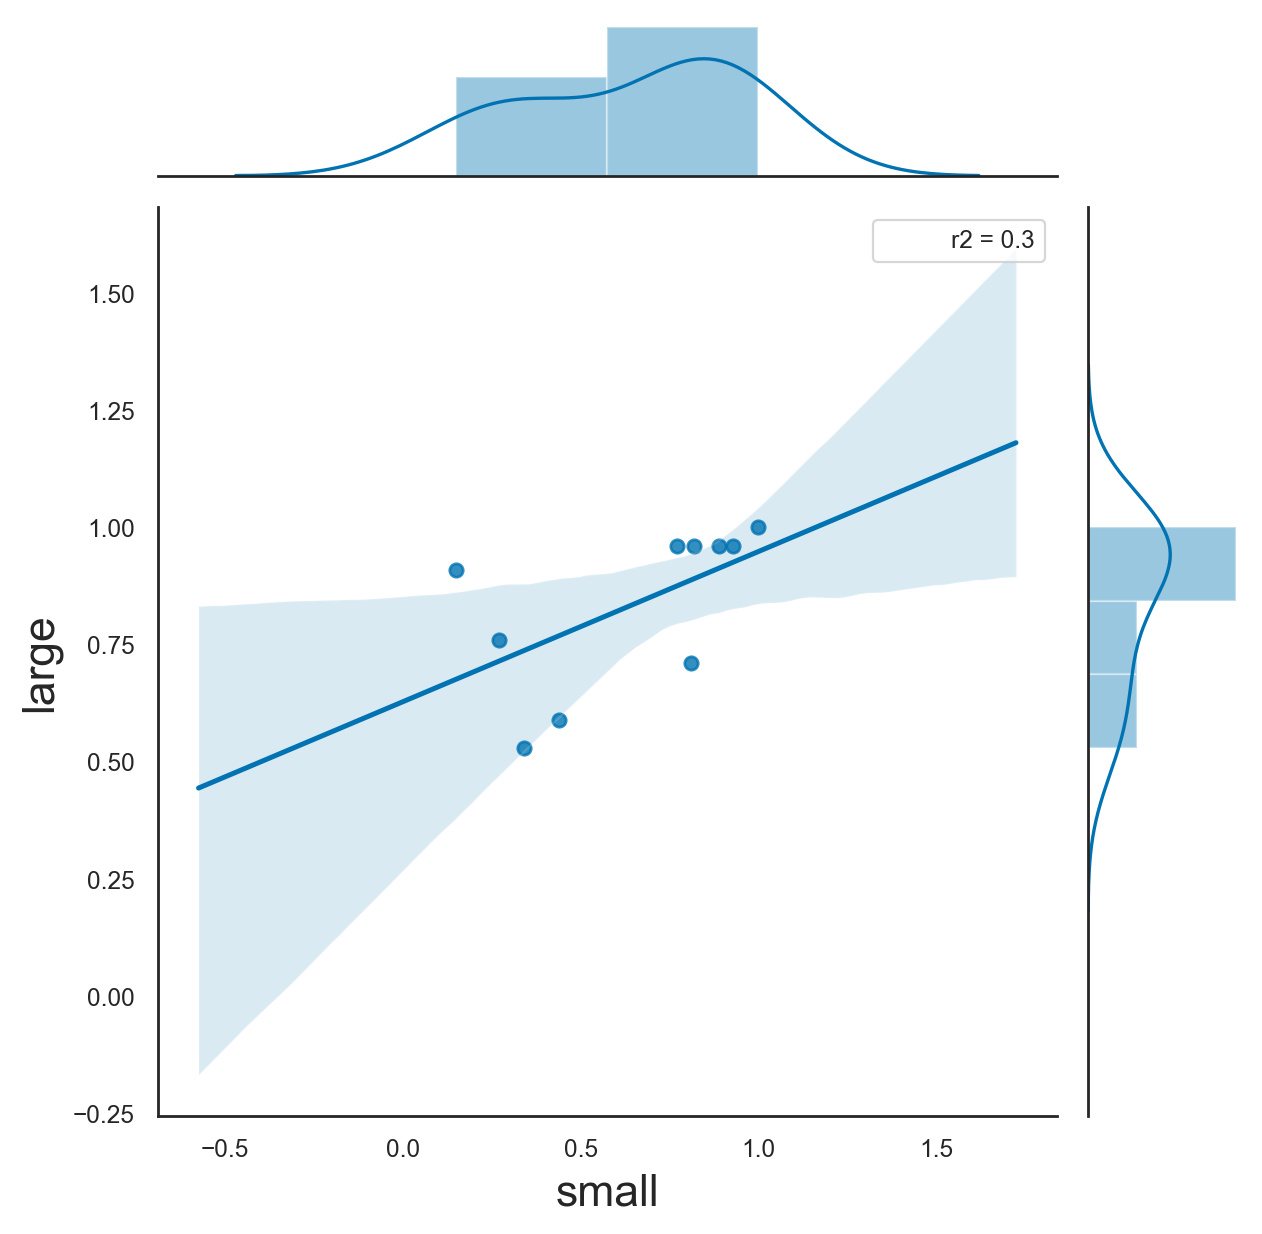

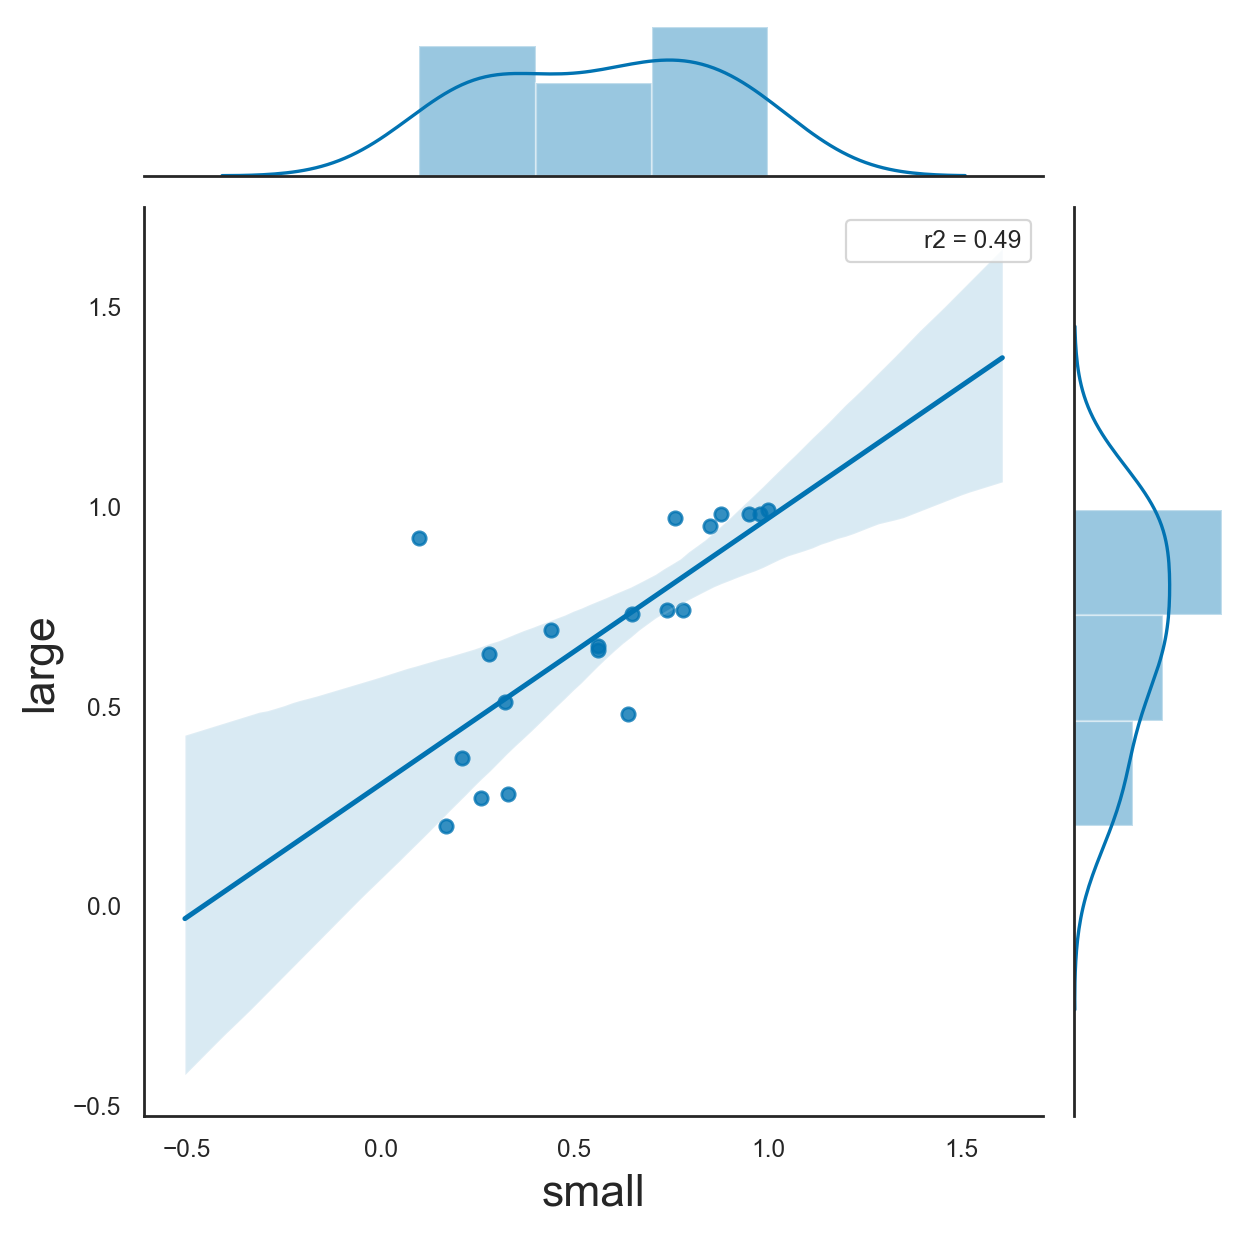

In [29]:
def r2(x, y):
    return stats.kendalltau(x, y)[0] ** 2


d = ds.markup.loc[(ds.markup['reg'] == 'brl_static6_all8') &
                          (ds.markup['blind'] == 1)]

selfreport = [ds.markup.loc[ds.markup['user']==u].iloc[0]['daily_braille_time'] for u in sorted(set(d.user))]
reading_time = [ds.markup.loc[ds.markup['user']==u].iloc[0]['reading_time'] for u in sorted(set(d.user))]

sns.jointplot (x=reading_time, y=large_stims_blind, kind='reg', stat_func=r2)
sns.utils.axlabel(xlabel='reading time', ylabel="classification", fontsize=16) #convert to speed

sns.jointplot (x=selfreport, y=large_stims_blind, kind='reg', stat_func=r2)
sns.utils.axlabel(xlabel='braille, hours/day', ylabel="classifcation", fontsize=16)

sns.jointplot (x=selfreport, y=reading_time, kind='reg', stat_func=r2)
sns.utils.axlabel(xlabel='braille, hours/day', ylabel="braille, reading time", fontsize=16)


sns.jointplot (x=small_stims_blind, y=large_stims_blind, kind='reg', stat_func=r2)
sns.utils.axlabel(xlabel='small', ylabel="large", fontsize=16)

sns.jointplot (x=small_stims_total, y=large_stims_total, kind='reg', stat_func=r2)
sns.utils.axlabel(xlabel='small', ylabel="large", fontsize=16)

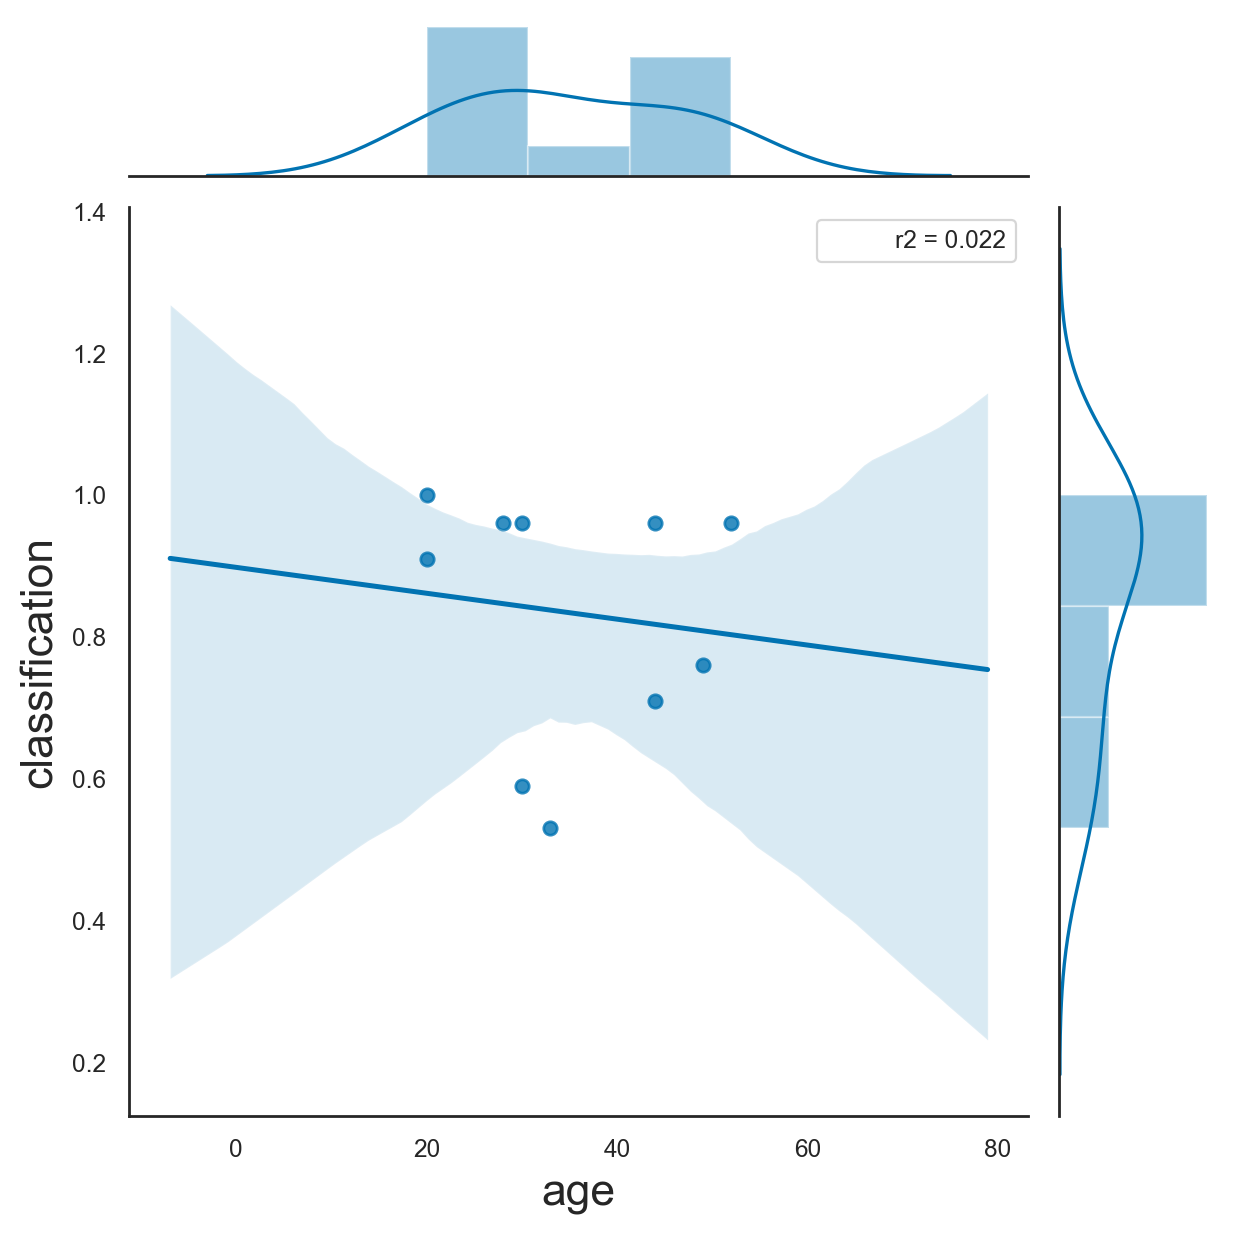

In [30]:

age = [ds.markup.loc[ds.markup['user']==u].iloc[0]['age'] for u in sorted(set(d.user))]

sns.jointplot (x=age, y=large_stims_blind, kind='reg', stat_func=r2)
sns.utils.axlabel(xlabel='age', ylabel="classification", fontsize=16) #convert to speed


In [108]:
np.median(blind_l)

0.925